Code cleaup. Need to 
1. remove repeated sentences due to vtt formatting
2. some words are concatenated together (helloBut--> hello But, swimming in a pool.We--> swimming in a pool. We)

In [2]:
import glob
import json
import regex as re
import os
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.corpus.reader import *
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiwonlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jiwonlee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
with open('../channelHolisticInfo.json', 'r') as j:
    channelHolisticInfo = json.loads(j.read())
channelHolisticInfoDf = pd.DataFrame.from_dict(channelHolisticInfo)
channelHolisticInfoDf.head()

,channelName,channelId,daysLiveAsOfLaunch,daysSinceFirstVideo,description,viewCount,subscriberCount,videoCount,firstUploadDate,subscribersPerYearSinceFirstUpload,viewCountPerYearSinceFirstUpload
0,Alex Clark,UCsDmESjqNPukDmVnuneLrqw,4392,4389,Funny vids about my life. I'm thankful for th...,471903125,4280000,317,2009-12-07T21:13:28Z,355935.292777,3.924462e+07
1,Alex Meyers,UCY6Ij8zOds0WJEeqCLOnqOQ,2348,2341,I make cartoons and sometimes video essays abo...,472627239,2870000,256,2015-07-18T11:43:37Z,447479.709526,7.369028e+07
2,WowRightMeow,UClN24S5-fc7LD0JJW0FdGWw,1946,1809,"Yo! I'm Jamie, a dorky human from Wales. Did a...",29732357,537000,33,2016-12-31T15:08:07Z,108349.917081,5.999066e+06
3,Andrei Terbea,UC3iNdSV_RQU7DHTGpqEW96w,3147,3149,Doing animated commentary and solving crimes w...,292193694,2860000,136,2013-04-30T20:01:32Z,331502.064147,3.386812e+07
4,Billy But Better,UC_52i6mlrzOZs_NEuSepzAg,2805,1736,"Yes, it's a foot.\n\nSocial Medias:\nTwitter -...",12166120,260000,23,2017-03-14T02:31:14Z,54665.898618,2.557969e+06


In [4]:
LIST_OF_CHANNEL_IDS = channelHolisticInfoDf['channelId'].tolist()
LIST_OF_CHANNEL_NAMES = channelHolisticInfoDf['channelName'].tolist()
LIST_OF_VIDEO_COUNT = channelHolisticInfoDf['videoCount'].tolist()

In [6]:
def generateListOfSentences(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        strippedLines = [line.strip() for line in lines if line.strip()] 
        removeDuplicatedLinesList = []
        for index in range(len(strippedLines)-1):
            removeDuplicatedLinesList.append(strippedLines[index])
    return list(set(removeDuplicatedLinesList))

# print(generateListOfSentences("UCAlxwHEm1bWWYoe5VCSQYEg/txt/_9KytbCHaXU.txt"))

def generateListOfWords(listOfSentences):
    all_stopwords = list(stopwords.words('english'))
    cleanedListOfWords = []
    for words in listOfSentences:
        word = re.split('[?."(),!) ]', words)
        for wo in word:
            if wo !='' and wo not in all_stopwords:
                cleanedListOfWords.append(wo)
    return cleanedListOfWords

def flattenList(list):
    flat_list = [item for sublist in list for item in sublist]
    return flat_list

#wordCloud[channelId] = all words from all .txt files with no stopwords
#sentenceCloud[channelId] = all sentences from all .txt files.

wordCloud = {}
sentenceCloud = {}
for channelId in LIST_OF_CHANNEL_IDS:
    listOfSentences = []
    listOfWords = []
    print(channelId, "has ", len(glob.glob(channelId+"/txt/*.txt")), "files to process.")
    for txtFilePath in glob.glob(channelId+"/txt/*.txt"):
        listOfSentences.append(generateListOfSentences(txtFilePath))
    flattenedListOfSentences = flattenList(listOfSentences) #<--
    flattendListOfWords = generateListOfWords(flattenedListOfSentences)

    sentenceCloud[channelId.split('/')[0]] = flattenedListOfSentences
    wordCloud[channelId.split('/')[0]] = flattendListOfWords
    print(channelId.split('/')[0], ": ", len(flattenedListOfSentences), "sentences total")
    print(channelId.split('/')[0], ": ", len(flattendListOfWords), "words total")

    # with open(channelId.split('/')[0]+"_wordCloud.txt", 'w') as f:
    #     json.dump(flattendListOfWords, f)
    # with open(channelId.split('/')[0]+"_sentenceCloud.txt", 'w') as f:
    #     json.dump(flattenedListOfSentences, f)

UCsDmESjqNPukDmVnuneLrqw has  298 files to process.
UCsDmESjqNPukDmVnuneLrqw :  35495 sentences total
UCsDmESjqNPukDmVnuneLrqw :  155629 words total
UCY6Ij8zOds0WJEeqCLOnqOQ has  250 files to process.
UCY6Ij8zOds0WJEeqCLOnqOQ :  81861 sentences total
UCY6Ij8zOds0WJEeqCLOnqOQ :  315581 words total
UClN24S5-fc7LD0JJW0FdGWw has  27 files to process.
UClN24S5-fc7LD0JJW0FdGWw :  5582 sentences total
UClN24S5-fc7LD0JJW0FdGWw :  20194 words total
UC3iNdSV_RQU7DHTGpqEW96w has  112 files to process.
UC3iNdSV_RQU7DHTGpqEW96w :  19042 sentences total
UC3iNdSV_RQU7DHTGpqEW96w :  76439 words total
UC_52i6mlrzOZs_NEuSepzAg has  23 files to process.
UC_52i6mlrzOZs_NEuSepzAg :  2594 sentences total
UC_52i6mlrzOZs_NEuSepzAg :  11450 words total
UCr3cBLTYmIK9kY0F_OdFWFQ has  80 files to process.
UCr3cBLTYmIK9kY0F_OdFWFQ :  9538 sentences total
UCr3cBLTYmIK9kY0F_OdFWFQ :  37907 words total
UCV6g95OBbVtFmN9uiJzkFqQ has  223 files to process.
UCV6g95OBbVtFmN9uiJzkFqQ :  11338 sentences total
UCV6g95OBbVtFm

In [103]:
#Actually create sentences. Not chunks. 

def generateListOfSentences(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        strippedLines = [line.strip() for line in lines if line.strip()] 
        removeDuplicatedLinesList = []
        for index in range(len(strippedLines)-1):
            removeDuplicatedLinesList.append(strippedLines[index])
        removeDuplicatedLinesList =[i for n, i in enumerate(removeDuplicatedLinesList) if i not in removeDuplicatedLinesList[:n]]
        # print(removeDuplicatedLinesList)
        passage = " ".join(removeDuplicatedLinesList)
        print(passage)
        # passageIntoSentences= split_into_sentences(str(passage))
        print(passageIntoSentences)
    return [i for n, i in enumerate(removeDuplicatedLinesList) if i not in removeDuplicatedLinesList[:n]]

# generateListOfSentences("UCAlxwHEm1bWWYoe5VCSQYEg/txt/_9KytbCHaXU.txt")

[]


Don't forget to find out how many caption files out of video published by channel

# Holistically

33


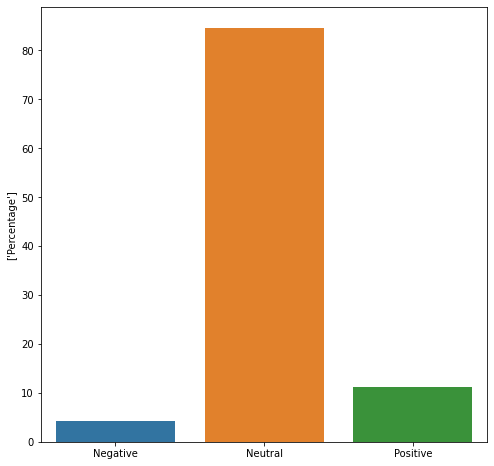

,neg,neu,pos,compound,words,label
0,0.0,1.0,0.0,0.0,Got,0
1,0.0,1.0,0.0,0.0,sunburned,0
2,0.0,1.0,0.0,0.0,dancing,0
3,0.0,1.0,0.0,0.0,waiting,0
4,0.0,1.0,0.0,0.0,evening,0


In [7]:
#General sentiment by words spoken by youtubers

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []

print(len(wordCloud.keys()))
for channelId in LIST_OF_CHANNEL_IDS:
    for words in wordCloud[channelId]:
        pol_score = sia.polarity_scores(words)
        pol_score['words']=words
        results.append(pol_score)
pd.set_option('display.max_columns', None, 'max_colwidth', None)
df = pd.DataFrame.from_records(results)
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1

import seaborn as sns
import matplotlib.pyplot as plt
fix, ax = plt.subplots(figsize=(8,8))
counts = df.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel(["Percentage"])
plt.show()

df.head()

In [8]:
df_positive_negative = df.loc[df['label'] != 0]
df_positive_negative.head()

,neg,neu,pos,compound,words,label
17,1.0,0.0,0.0,-0.1531,stops,-1
21,1.0,0.0,0.0,-0.1027,Nah,-1
22,1.0,0.0,0.0,-0.1027,nah,-1
23,1.0,0.0,0.0,-0.1027,nah,-1
24,1.0,0.0,0.0,-0.1027,nah,-1


In [9]:
print(df_positive_negative.label.value_counts())

 1    224624
-1     85038
Name: label, dtype: int64


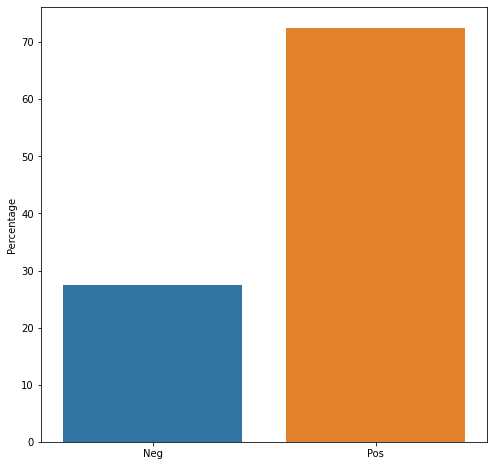

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
counts = df_positive_negative.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Neg', 'Pos'])
ax.set_ylabel('Percentage')
plt.show()

Basically, compared to redditors, animation youtubers are more 'positive'

# By Channel by words

In [28]:
channelId_to_df = {}
sia = SIA()
for channelId in LIST_OF_CHANNEL_IDS:
    results = []
    for words in wordCloud[channelId]:
        pol_score = sia.polarity_scores(words)
        pol_score['words']=words
        results.append(pol_score)
    pd.set_option('display.max_columns', None, 'max_colwidth', None)
    df = pd.DataFrame.from_records(results)
    channelId_to_df[channelId] = df
df[150:200]

,neg,neu,pos,compound,words
150,0.0,1.0,0.0,0.0000,maid
151,0.0,1.0,0.0,0.0000,Everything
152,0.0,0.0,0.0,0.0000,I
153,0.0,1.0,0.0,0.0000,touch
154,0.0,1.0,0.0,0.0000,turns
155,1.0,0.0,0.0,-0.4215,waste
156,0.0,1.0,0.0,0.0000,*Knock
157,0.0,1.0,0.0,0.0000,Knock
158,0.0,1.0,0.0,0.0000,Knock*
159,0.0,1.0,0.0,0.0000,Duh


In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def generateWordCloud(pos_words_str, neg_words_str):
    wordcloud_positive = WordCloud(background_color='white').generate(pos_words_str)
    wordcloud_negative = WordCloud().generate(neg_words_str)

    plt.imshow(wordcloud_positive, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    plt.imshow(wordcloud_negative, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [30]:
top_20_pos_words = {}
top_20_neg_words = {}
scores= {}
for channelId in LIST_OF_CHANNEL_IDS:
    target_df = channelId_to_df[channelId]
    positive_words = list(target_df.loc[target_df['pos']==1].words)
    positive_frequency = FreqDist(positive_words)
    pos_freq = positive_frequency.most_common(20)
    negative_words = list(target_df.loc[target_df['neg']==1].words)
    negative_frequency = FreqDist(negative_words)
    neg_freq = negative_frequency.most_common(20)
    top_20_pos_words[channelId] = pos_freq
    top_20_neg_words[channelId] = neg_freq

    pos_words = [str(p) for p in pos_freq]
    pos_words_str = ', '.join(pos_words)
    neg_words = [str(n) for n in neg_freq]
    neg_words_str = ', '.join(neg_words)
    # generateWordCloud(pos_words_str, neg_words_str)

    scores[channelId] = sum(target_df['compound'])/len(target_df)
print(scores)

{'UCsDmESjqNPukDmVnuneLrqw': 0.03598800095098049, 'UCY6Ij8zOds0WJEeqCLOnqOQ': 0.03490942578925727, 'UClN24S5-fc7LD0JJW0FdGWw': 0.03125584827176393, 'UC3iNdSV_RQU7DHTGpqEW96w': 0.01964876306597452, 'UC_52i6mlrzOZs_NEuSepzAg': 0.026322620087336192, 'UCr3cBLTYmIK9kY0F_OdFWFQ': 0.022758392908961665, 'UCV6g95OBbVtFmN9uiJzkFqQ': 0.023039981595207707, 'UCgCKYs56-LKEPGQ99DzqQOg': 0.031858909310451676, 'UCOwxx9VnEnlFKt5EB70KTzQ': 0.020200437534182557, 'UC2Ds30pkifFVD0CE08wF50g': 0.02362694668117498, 'UC7UGbBVrqLlq6CRxWWUmyKw': 0.019298051268736693, 'UCn1XB-jvmd9fXMzhiA6IR0w': 0.030018270034608576, 'UCFeqAfEuKm7lIg2ddQzh61A': 0.03758699354558893, 'UCAlxwHEm1bWWYoe5VCSQYEg': 0.03718808725854707, 'UCz7iJPVTBGX6DNO1RNI2Fcg': 0.0069941702652683325, 'UCOAUz4d1NUNxSHh_SOJtdGQ': 0.0322028140226287, 'UCGGTAB19HlHEWPwwmxHsEKA': 0.029578237764072896, 'UCOsATJw-IZgqGT8MFrHjKGg': 0.0334704793028321, 'UCsKVP_4zQ877TEiH_Ih5yDQ': 0.02886641732407265, 'UCOinp9hALPUcZeoL3Kmaviw': 0.030129082855275432, 'UCGwu0nbY

# By sentences

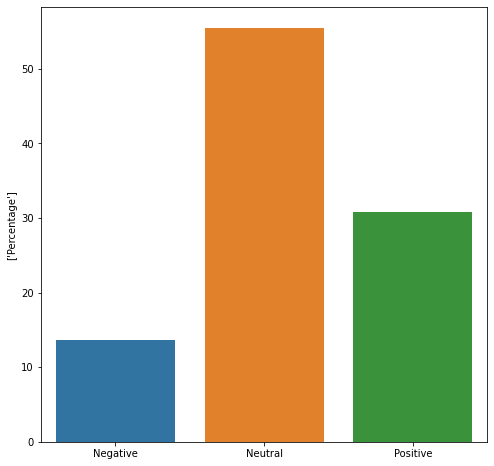

,neg,neu,pos,compound,sentence,label
0,0.535,0.465,0.0,-0.3182,I lost my suitcase,-1
1,0.000,1.000,0.0,0.0000,Twitter! Insta!,0
2,0.345,0.655,0.0,-0.4215,So when the carriage stops my new life will begin (Nah nah nah nah nah),-1
3,0.000,1.000,0.0,0.0000,(All you have to do all you have to do all you have to do all you have to do all you have to do),0
4,0.000,1.000,0.0,0.0000,"If you find this week's, Let me know in Twitter or Instagram.",0


In [43]:
#General sentiment by words spoken by youtubers

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []
for channelId in LIST_OF_CHANNEL_IDS:
    for sentence in sentenceCloud[channelId]:
        pol_score = sia.polarity_scores(sentence)
        pol_score['sentence']=sentence
        results.append(pol_score)
pd.set_option('display.max_columns', None, 'max_colwidth', None)
df = pd.DataFrame.from_records(results)
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1

import seaborn as sns
import matplotlib.pyplot as plt
fix, ax = plt.subplots(figsize=(8,8))
counts = df.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel(["Percentage"])
plt.show()

df.head()

# By channel by sentences

In [38]:
sentenceCloud[LIST_OF_CHANNEL_IDS[28]]

['Imagination, life is your creation!',
 'Think it\'s some kind of game to you? I\'LL SMACK YOU!"',
 'heaven? (take that, demonetization)',
 'Afro: "So why are you blaming me?!"',
 '2. He\'s colorblind as fuuucccckkkk."',
 'With our underdeveloped brains,',
 'Young Tabbes: "Wha-?"',
 'Reebok: "I think it was Afro."',
 '"N-',
 "Yeah I know that's a real beautiful way to start.",
 "play fighting which wasn't really play fighting and other feisty things.",
 'Reebok: "We\'re in a church."',
 "You think I'm spending all summer vacation in the same room as you?!?!",
 'Young Tabbes: "No, Reebok, that\'s not the situation right now!"',
 "-yeah, I know I'm old as fuck-",
 'This was "Afro", the oldest and toughest of the bunch',
 'This story takes place in a church basement. (Yikes)',
 'Well Afro, who was the oldest of our group told us;',
 '*damns and oohs*',
 'Maybe there\'s a key or something else in this room that can help us."',
 'Gal: "What? You think this is some kind of game, huh?',
 'Yo

In [94]:
#General sentiment by words spoken by youtubers

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
channelId_to_sentencedf = {}

for channelId in LIST_OF_CHANNEL_IDS:
    results = []
    for sentence in sentenceCloud[channelId]:
        pol_score = sia.polarity_scores(sentence)
        pol_score['sentence']=sentence
        results.append(pol_score)
    pd.set_option('display.max_columns', None, 'max_colwidth', None)
    df = pd.DataFrame.from_records(results)
    channelId_to_sentencedf[channelId] = df
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1


In [95]:
from IPython.display import display

for channelId in LIST_OF_CHANNEL_IDS:
    display(channelId_to_sentencedf[channelId][200:250])

,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,beginning of a magical night
201,0.000,0.625,0.375,0.5574,positive since so many people [ __ ] on
202,0.341,0.659,0.000,-0.4767,i don't think the traffic is any worse
203,0.000,0.594,0.406,0.6249,awesome when i first got here the food i
204,0.260,0.740,0.000,-0.2755,the sand i don't like the hot sun
205,0.000,1.000,0.000,0.0000,to get in this video so
206,0.000,0.843,0.157,0.0772,angeles you want to go to apollonia or
207,0.000,1.000,0.000,0.0000,there's way too many
208,0.000,1.000,0.000,0.0000,how am i supposed to know the difference
209,0.000,0.759,0.241,0.2263,i bet your buddy alex here surprised you


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,but at least he never did that!
201,0.177,0.823,0.000,-0.0191,It doesn't matter what I show you
202,0.000,1.000,0.000,0.0000,Is that Charlie?
203,0.000,1.000,0.000,0.0000,I saw how the characters change and all that
204,0.000,0.577,0.423,0.5267,and that Bella is alive and everything's fine.
205,0.000,1.000,0.000,0.0000,"Part 1 video,"
206,0.000,1.000,0.000,0.0000,"you know, coming to the end of series is always"
207,0.000,1.000,0.000,0.0000,you need to get your thirst under control.
208,0.000,0.510,0.490,0.5859,Alright its just... its just a nice wholesome
209,0.000,1.000,0.000,0.0000,the beginning.


,neg,neu,pos,compound,sentence
200,0.271,0.729,0.000,-0.3818,I'm trying to do an internal screaming noise.
201,0.000,1.000,0.000,0.0000,You're not into this
202,0.000,0.575,0.425,0.6351,It's honestly not as embarrassing as you might think
203,0.000,1.000,0.000,0.0000,"I mean, can you believe that thick brows were generally considered uncool back in 2007?"
204,0.176,0.824,0.000,-0.3096,"That I didn't need to be nervous and police say no Amy, you know, you don't want this maybe one day but not now"
205,0.000,1.000,0.000,0.0000,Don't expect that
206,0.000,1.000,0.000,0.0000,He bought me a white gold necklace and bangle
207,0.103,0.734,0.163,0.3919,But 13-year old me had no idea what was considered normal and trust me. I was thinking about burning it up with him
208,0.152,0.848,0.000,-0.5267,But I knew in my heart and gut that it wasn't right for me to do something that made me uncomfortable
209,0.176,0.824,0.000,-0.5423,I was afraid to bring it up with my mum in case she would belittle me somehow and I was too awkward to bring it


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,going on and if there was ever the need
201,0.000,1.000,0.000,0.0000,through the roof it was a very
202,0.000,1.000,0.000,0.0000,named after it and the latest jeffree
203,0.000,1.000,0.000,0.0000,information as to who might be involved
204,0.000,1.000,0.000,0.0000,they took thousands of lip liners and
205,0.000,1.000,0.000,0.0000,in higher levels of this operation now
206,0.000,1.000,0.000,0.0000,some reason in the past few months
207,0.000,1.000,0.000,0.0000,point I'm imagining some people may be
208,0.000,1.000,0.000,0.0000,gone to the bathroom and then when I got
209,0.139,0.567,0.295,0.3352,them too much credit I don't want to


,neg,neu,pos,compound,sentence
200,0.087,0.913,0.000,-0.2960,Everyone just referred to him by his last name. In fact whenever I called him by his first name he would stop and give me
201,0.000,0.656,0.344,0.8750,Pillars and around Corners just to wait for the perfect moment to scoop people with like maximum strength when they least expected it he was
202,0.000,0.444,0.556,0.6124,"like a Skeleton, and he'd be like"
203,0.118,0.553,0.329,0.4696,"This weird look like ""what did you just call me?"" Okay?"
204,0.000,0.842,0.158,0.4939,Primal reflex to cover my nipples whenever someone made a sudden hand movement anywhere around my upper torso area
205,0.081,0.812,0.107,0.1779,There was no word in the English dictionary that was safe sooner or later everyone who knew shimada-san which was most people in school
206,0.000,1.000,0.000,0.0000,Simadasan was probably one of the scrawniest guys in school really skinny
207,0.000,1.000,0.000,0.0000,"It's middle school, because of shimada and his erratic scooping ambushes"
208,0.000,0.889,0.111,0.3612,It's been like half a week since I hit 1000 and I didn't say anything to you guys so slow down on the subs
209,0.000,0.887,0.113,0.4201,speaking of touching you really like scooping people. scooping if you don't already know it's the act of lifting one or both of


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,[Music]
201,0.000,1.000,0.000,0.0000,laundry detergent or light yourself on
202,0.000,1.000,0.000,0.0000,first heard that so last time I was
203,0.000,1.000,0.000,0.0000,made is higher than ever before the
204,0.191,0.465,0.344,0.3919,wrong person but the thought was nice
205,0.000,1.000,0.000,0.0000,but with that said I do know some
206,0.000,1.000,0.000,0.0000,our content being made is also higher
207,0.268,0.732,0.000,-0.2960,something no one has ever said before
208,0.275,0.725,0.000,-0.2263,always forget and I do think Charlie
209,0.000,1.000,0.000,0.0000,for condoms now what I am actually


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,why hasn't he picked the class there's
201,0.000,1.000,0.000,0.0000,and I don't know you but I'm three ranks
202,0.000,1.000,0.000,0.0000,didn't pick a class back there is
203,0.000,0.686,0.314,0.4939,hand I'm sponsored by Red Bull you know
204,0.000,0.606,0.394,0.5994,away from mega master super class so
205,0.000,0.706,0.294,0.3612,seems like one of my teammates knows
206,0.161,0.839,0.000,-0.0387,hey sorry about this but I noticed you
207,0.157,0.843,0.000,-0.0772,am i hey dude I'm sorry man I can't find
208,0.000,0.737,0.263,0.3612,I know these maps like the back of my
209,0.000,0.619,0.381,0.5106,yeah go get a man ah all right well it


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,"but I mean, and now the situation, it"
201,0.296,0.704,0.000,-0.2732,wanting to date girls being low
202,0.000,0.612,0.388,0.5859,"are around the lines of oh, wow."
203,0.000,1.000,0.000,0.0000,And we will be also seeing there votes
204,0.000,1.000,0.000,0.0000,And then they may lean on your shoulder
205,0.783,0.217,0.000,-0.5574,Curt: shit.
206,0.000,1.000,0.000,0.0000,It doesn't say that on the website.
207,0.000,1.000,0.000,0.0000,I'm going to.
208,0.000,1.000,0.000,0.0000,you'd be asking them questions.
209,0.000,0.753,0.247,0.3182,be sure to check out the last one.


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,More than half of a friggin' million subscribers
201,0.000,1.000,0.000,0.0000,And I was never able to use it again
202,0.000,1.000,0.000,0.0000,"I'm j-j-just a little nervous."""
203,0.000,1.000,0.000,0.0000,"I figured why the heck not?! If I make more animations in this style,"
204,0.000,1.000,0.000,0.0000,"""Aww, you have an Arcanine?"
205,0.000,1.000,0.000,0.0000,"""Denise?"""
206,0.000,1.000,0.000,0.0000,"Magikarp, and then it turns into a level 56 Dragonite in one go."
207,0.000,1.000,0.000,0.0000,Legendaries were obviously more expensive
208,0.000,1.000,0.000,0.0000,I had a chart for all the Pokemon prices
209,0.000,1.000,0.000,0.0000,"""You're drawing in art class is going to be featured in the Queens Art Museum."""


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,know whoever leaves gets replaced with a
201,0.000,0.556,0.444,0.4588,roommates to humor you with okay so
202,0.000,1.000,0.000,0.0000,are they even payin rent for
203,0.000,1.000,0.000,0.0000,learn and grow with short classes that
204,0.000,1.000,0.000,0.0000,bit your busy routine Skillshare is also
205,0.000,0.602,0.398,0.5106,away two free months of premium
206,0.000,0.765,0.235,0.2846,be fun sometimes but it can also be
207,0.000,0.403,0.597,0.8126,a great jolly time in the living room
208,0.000,1.000,0.000,0.0000,it's out of this world I couldn't
209,0.000,0.787,0.213,0.2263,a nap okay these guys sleep more than 14


,neg,neu,pos,compound,sentence
200,0.000,0.741,0.259,0.2732,just man you know what Oh God
201,0.000,0.706,0.294,0.3612,you like that you know what what
202,0.000,1.000,0.000,0.0000,really far from Italy I was watching
203,0.000,1.000,0.000,0.0000,I didn't even talk to the dude I know
204,0.355,0.645,0.000,-0.5118,who almost died from the turret nowhere
205,0.000,0.761,0.239,0.2960,happened yeah what did Dan know the dude
206,0.000,0.741,0.259,0.4215,League oh oh oh baby nice why didn't you
207,0.000,1.000,0.000,0.0000,listening to them
208,0.190,0.476,0.333,0.4215,look in love with Marko fire dude Micha
209,0.000,0.653,0.347,0.4927,coming out of a bush is really good


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,the royal ontario museum
201,0.000,1.000,0.000,0.0000,the side views always include standard
202,0.357,0.388,0.256,-0.3182,comfortable in what the hell are you
203,0.000,0.408,0.592,0.4404,end on a good
204,0.000,1.000,0.000,0.0000,videos i really mean it
205,0.000,1.000,0.000,0.0000,understand
206,0.000,1.000,0.000,0.0000,constrictions of course
207,0.000,1.000,0.000,0.0000,blueprints they're just called
208,0.000,1.000,0.000,0.0000,a structural vertical beam a column it's
209,0.000,0.485,0.515,0.6486,a column boy i'm sure glad my tuition


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,notebooks you weren't supposed to take
201,0.000,1.000,0.000,0.0000,get me a new notebook or explain to them
202,0.000,1.000,0.000,0.0000,[Music]
203,0.000,0.450,0.550,0.7269,part in my childhood I was a pretty good
204,0.000,1.000,0.000,0.0000,you would draw a car and I remember
205,0.292,0.708,0.000,-0.5106,and my dumb little kid self took it home
206,0.000,1.000,0.000,0.0000,would be accurate but the picture
207,0.193,0.241,0.566,0.4767,kindergarten rebel yeah I was like
208,0.000,1.000,0.000,0.0000,trial of Verve premium today
209,0.383,0.617,0.000,-0.4767,ruined my school notebook instead I'm


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,apparently they're called furries I'm
201,0.000,1.000,0.000,0.0000,during the summer people always thought
202,0.293,0.707,0.000,-0.4404,so just do all these scared and dude
203,0.000,1.000,0.000,0.0000,Susie and then from there I stumbled
204,0.000,0.843,0.157,0.0772,the sport want to see me do a mediocre
205,0.000,1.000,0.000,0.0000,high school I got into dota then
206,0.000,1.000,0.000,0.0000,upon a bunch of other channels also
207,0.000,1.000,0.000,0.0000,jump serve wanna see me fall
208,0.000,0.753,0.247,0.3182,just calm yourself so you guys send me
209,0.000,1.000,0.000,0.0000,sushi and fries and pizza ribs baked


,neg,neu,pos,compound,sentence
200,0.275,0.725,0.000,-0.2263,pieces of paper covering a tits and
201,0.260,0.740,0.000,-0.2755,do that keem wouldn't like very much
202,0.000,1.000,0.000,0.0000,left his twitter logged on at home
203,0.000,1.000,0.000,0.0000,second-class citizen jesus christ
204,0.000,1.000,0.000,0.0000,it is for keem right
205,0.000,1.000,0.000,0.0000,him to get five
206,0.000,0.588,0.412,0.2732,woman beater as well
207,0.000,1.000,0.000,0.0000,just heard it from keemstar himself
208,0.000,0.645,0.355,0.5106,would encourage people to come and do
209,0.000,1.000,0.000,0.0000,sport


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,crossing games you might just get a
201,0.303,0.697,0.000,-0.1877,not a chance nintendo doesn't know
202,0.000,0.602,0.398,0.5106,this is a free browser extension so
203,0.000,0.625,0.375,0.3400,i've played animal crossing for a
204,0.000,1.000,0.000,0.0000,new thing coming in june and since it
205,0.310,0.690,0.000,-0.4019,the main problem with previous titles in
206,0.000,1.000,0.000,0.0000,down the game again i don't think i've
207,0.000,1.000,0.000,0.0000,pandemic going on and
208,0.000,0.795,0.205,0.2023,the top of the description and you can
209,0.000,1.000,0.000,0.0000,horizons


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,as weren't originally applied to any
201,0.000,0.706,0.294,0.3612,were used as venues for things like
202,0.000,1.000,0.000,0.0000,but I mean pac-man eats fruit was there
203,0.000,0.580,0.420,0.4404,inflation and stuff better start
204,0.000,0.723,0.277,0.3182,video so there was a lot of cool
205,0.000,1.000,0.000,0.0000,Qbert who are these guys who are you
206,0.000,1.000,0.000,0.0000,let's go check it out oh this is just a
207,0.000,1.000,0.000,0.0000,let's go cash in our tickets sir I have
208,0.000,0.294,0.706,0.8625,yeah you but uh that's perfectly fine
209,0.000,1.000,0.000,0.0000,investing or learn what inflation means


,neg,neu,pos,compound,sentence
200,0.000,0.513,0.487,0.4215,connection allow for daytime oh okay I
201,0.000,1.000,0.000,0.0000,wondering is it possible if you can draw
202,0.000,1.000,0.000,0.0000,you use hover we're not talking about
203,0.000,0.737,0.263,0.3612,I can hello would you like to have sex
204,0.000,1.000,0.000,0.0000,real um hi ice cream I'm a really big
205,0.255,0.510,0.235,-0.0516,this solution is that I'm lazy and I
206,0.000,1.000,0.000,0.0000,mean I'm assuming you're asking it's a
207,0.000,0.309,0.691,0.7717,on I funny they're amazing you're
208,0.000,1.000,0.000,0.0000,same thing so refer to question the last
209,0.000,1.000,0.000,0.0000,hi I'm editor-in-chief from French


,neg,neu,pos,compound,sentence
200,0.508,0.492,0.000,-0.4767,asking for fake pics
201,0.000,1.000,0.000,0.0000,but so we know it's real
202,0.000,0.731,0.269,0.3774,that so make sure to check it out
203,0.000,1.000,0.000,0.0000,just a warm-up you've been drawing the
204,0.000,1.000,0.000,0.0000,works out
205,0.000,1.000,0.000,0.0000,some converse
206,0.000,1.000,0.000,0.0000,come here come say hi t
207,0.000,1.000,0.000,0.0000,a picture of your shoes if you made it
208,0.000,1.000,0.000,0.0000,oh and here's mine
209,0.000,1.000,0.000,0.0000,wearing shoes i'm gonna just give her


,neg,neu,pos,compound,sentence
200,0.000,0.737,0.263,0.3612,thank you so much to all the old
201,0.000,1.000,0.000,0.0000,been working with other youtubers on
202,0.000,1.000,0.000,0.0000,I'm doing so that's that's another
203,0.000,0.642,0.358,0.4201,the beginning and especially thank you
204,0.000,0.455,0.545,0.3818,that's fine that's fine too
205,0.216,0.603,0.181,-0.1027,sub box from you you lazy sloth well you
206,0.000,0.843,0.157,0.0772,that's it I want to say that's it uh
207,0.000,1.000,0.000,0.0000,know I'm still talking because I just
208,0.000,1.000,0.000,0.0000,next video because it'll actually be a
209,0.000,0.723,0.277,0.3182,the 151 original Pokemon collab which is


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,Jaiden: So I'm gonna reveal a clue that I have been provided.
201,0.000,0.762,0.238,0.3612,"Jaiden: And then the other one's just like, snippy."
202,0.169,0.831,0.000,-0.0572,He doesn't want to be a duel monster.
203,0.000,0.698,0.302,0.0772,"""I just want lettuce."""
204,0.000,0.572,0.428,0.4574,Jaiden: Oh yes it is!
205,0.000,1.000,0.000,0.0000,Jaiden: You can't sue them.
206,0.000,0.828,0.172,0.3612,"Jaiden: He's like, trying to sleep and then he just wakes up to:"
207,0.000,0.221,0.779,0.5449,YEAH! Hahahaha!
208,0.000,1.000,0.000,0.0000,Jaiden: Hi everyone i-i-i-i-uh its Jaiden.
209,0.000,1.000,0.000,0.0000,"Jaiden: Oh, there we go!"


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,situation but I just can't put my finger
201,0.000,1.000,0.000,0.0000,perform in is a style that's not even
202,0.000,1.000,0.000,0.0000,the comment section below
203,0.000,1.000,0.000,0.0000,schools who require a portfolio to get
204,0.000,1.000,0.000,0.0000,animation program a graduate program all
205,0.000,1.000,0.000,0.0000,out what their timeline is Nikita Ward
206,0.000,0.674,0.326,0.4404,for the entire Creative Suite you can
207,0.000,1.000,0.000,0.0000,I haven't looked up the prices but I
208,0.000,0.496,0.504,0.7269,an orange is created by the awesome and
209,0.000,1.000,0.000,0.0000,claiming my work as his own for years


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,graphics are fucking downgrade
201,0.000,1.000,0.000,0.0000,and changing those graphics without
202,0.000,1.000,0.000,0.0000,robot huh
203,0.000,0.511,0.489,0.5842,not a big deal no good graphics don't
204,0.000,1.000,0.000,0.0000,now
205,0.239,0.761,0.000,-0.2960,no i'm not saying that the new geometry
206,0.000,0.735,0.265,0.2023,also important i'll take it however
207,0.434,0.566,0.000,-0.6808,these methods can work hell i mean the
208,0.000,1.000,0.000,0.0000,of the colossus fucking halo infinite is
209,0.404,0.596,0.000,-0.6214,it's so fucking bad it doesn't it


,neg,neu,pos,compound,sentence
200,0.260,0.740,0.000,-0.2755,And since neither felt like they had
201,0.000,1.000,0.000,0.0000,The people wanted Russia
202,0.000,1.000,0.000,0.0000,"""Cool."""
203,0.559,0.441,0.000,-0.5859,"This will ruin us."""
204,0.589,0.411,0.000,-0.6486,"his dead body forever."""
205,0.000,0.549,0.451,0.6249,I need someone with a great military mind
206,0.000,1.000,0.000,0.0000,leaders were released
207,0.000,0.667,0.333,0.3612,that promised to give the people
208,0.000,0.635,0.365,0.3182,the truth seems to be a
209,0.000,0.652,0.348,0.4939,day and night to save the country.


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,and Little kyuubi cuticular music And
201,0.000,1.000,0.000,0.0000,we 'll have on the last night a DJ person
202,0.367,0.633,0.000,-0.4404,the weeping hental20 my screen chemicals
203,0.000,1.000,0.000,0.0000,Could you everything you need to know
204,0.000,0.299,0.701,0.5719,intelligent B Cleaner Bangladesh because
205,0.000,0.594,0.406,0.6249,they served with English What is a great
206,0.000,1.000,0.000,0.0000,I must ask where it is when you said I
207,0.000,0.357,0.643,0.6597,Smart art lightening support helsing
208,0.000,1.000,0.000,0.0000,and Karan New York city at night and
209,0.000,0.702,0.298,0.1779,a Poker caramel spirit Irina Shayk


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,walk around the neighborhood banging
201,0.508,0.492,0.000,-0.7351,over Ivana was tired and sick and needed
202,0.000,1.000,0.000,0.0000,muttering my name as if to get the
203,0.000,0.693,0.307,0.4767,mutual friends of ours and what you guys
204,0.000,1.000,0.000,0.0000,2019 is next month and I will actually
205,0.000,0.549,0.451,0.4767,flirty comments like man that is some
206,0.149,0.851,0.000,-0.0572,knew I'd have to follow if I didn't want
207,0.000,1.000,0.000,0.0000,pots and pans and I followed them but
208,0.000,0.323,0.677,0.2732,Oh God
209,0.423,0.577,0.000,-0.2960,we were worried about


,neg,neu,pos,compound,sentence
200,0.000,0.606,0.394,0.5994,I mean super Godzilla won't let it get
201,0.000,1.000,0.000,0.0000,half being Mexican and that being the
202,0.000,1.000,0.000,0.0000,I didn't and I didn't need it my foots
203,0.302,0.698,0.000,-0.3818,who gives a crap about what other people
204,0.000,1.000,0.000,0.0000,for it figuring out ways to live a
205,0.000,1.000,0.000,0.0000,opening up more or to make you feel
206,0.268,0.732,0.000,-0.2960,people think stop you from doing stuff
207,0.000,1.000,0.000,0.0000,wasn't until the end of junior year when
208,0.000,1.000,0.000,0.0000,drawing the fact that I had a youtube
209,0.000,0.706,0.294,0.3612,have called me something like hot fudge


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,And she went on to do a few movies
201,0.150,0.638,0.213,0.2240,"'I always thought you were cute, do you not like me'"
202,0.157,0.562,0.281,0.2732,"she's like 'nah, nah , nah... I'm single'"
203,0.000,1.000,0.000,0.0000,*Wow you really put some thought into it*
204,0.000,0.737,0.263,0.3612,"We pass a Wonder Woman billboard, and she's like"
205,0.000,0.518,0.482,0.4199,She's like 'No... wait!'
206,0.000,1.000,0.000,0.0000,Focus on your family
207,0.000,1.000,0.000,0.0000,'So much has happened'
208,0.000,1.000,0.000,0.0000,I got that gig
209,0.000,0.789,0.211,0.1531,Be careful the choices that you make


,neg,neu,pos,compound,sentence
200,0.000,0.914,0.086,0.1531,"Ok, so I don't know if this is some ""art entity"" just messing around with us but everytime there's"
201,0.000,1.000,0.000,0.0000,"I don't know exactly why I do it, I just think it became a habit for me"
202,0.000,0.877,0.123,0.4201,"So thank you to anyone who watched this video, this is my um, this is my debut video, My first one."
203,0.263,0.737,0.000,-0.4314,"""So can you draw me?"". ""No why the fuck?!"""
204,0.115,0.826,0.060,-0.2960,"Number three, so there's another way you could find your mistakes without having anyone else to evaluate it for you."
205,0.000,1.000,0.000,0.0000,I guess it's just what your drawing skills would be on average
206,0.000,1.000,0.000,0.0000,"What's considered normal? I don't know, you tell me."
207,0.000,1.000,0.000,0.0000,"And I decided to do something,"
208,0.000,0.613,0.387,0.7430,"something I was comfortable with, or something that I actually had an interest for"
209,0.000,0.683,0.317,0.7876,"But in all honesty, I tend to deal with some of these, as well, so I try to pick-"


,neg,neu,pos,compound,sentence
200,0.686,0.125,0.188,-0.6087,"feeling more scared, anxious,"
201,0.000,1.000,0.000,0.0000,long-term as a doctor
202,0.000,1.000,0.000,0.0000,and there's not that
203,0.000,0.536,0.464,0.3818,to accept foreign currency
204,0.000,1.000,0.000,0.0000,"of me working there,"
205,0.000,0.580,0.420,0.4404,And I hope that I can continue
206,0.000,1.000,0.000,0.0000,I recognize old Terry walking in.
207,0.000,1.000,0.000,0.0000,"And if I ever get the urge to run away,"
208,0.000,1.000,0.000,0.0000,"about history, philosophy, medicine,"
209,0.000,0.610,0.390,0.4939,using Runescape to grow their wealth.


,neg,neu,pos,compound,sentence
200,0.000,1.000,0.000,0.0000,beginning of the year you can calculate
201,0.000,1.000,0.000,0.0000,all right let's let's try it again
202,0.000,0.714,0.286,0.3400,kind of gentler approach to school of
203,0.000,1.000,0.000,0.0000,that's what mrs. Dolan des did to me
204,0.000,1.000,0.000,0.0000,signed wide ESG poster is at links Forte
205,0.000,1.000,0.000,0.0000,my last class of the day left for me to
206,0.000,0.496,0.504,0.7269,chance to go to one of our great
207,0.342,0.541,0.117,-0.5423,fraid you see if you want to ruin
208,0.000,0.729,0.271,0.3818,the extra credit in the syllabus at the
209,0.000,1.000,0.000,0.0000,someone emotionally you don't start off


,neg,neu,pos,compound,sentence
200,0.000,0.413,0.587,0.6901,very good response that would relieve
201,0.000,1.000,0.000,0.0000,much everything that's going to happen
202,0.000,1.000,0.000,0.0000,so in conclusion even though doki-doki
203,0.000,0.735,0.265,0.2023,you doing playing a dating game and
204,0.000,1.000,0.000,0.0000,the same thing happens when I found out
205,0.000,1.000,0.000,0.0000,gonna try and he was single so I figured
206,0.000,0.563,0.437,0.4767,I started messaging my friends with
207,0.000,0.610,0.390,0.4939,another friend who has a gaming channel
208,0.000,1.000,0.000,0.0000,gotten into watching Matt Pat's channel
209,0.000,1.000,0.000,0.0000,club and it's really not a dating game


,neg,neu,pos,compound,sentence,label


In [12]:
df_positive_negative = df.loc[df['label'] != 0]
df_positive_negative.head()

,neg,neu,pos,compound,sentence,label
0,0.000,0.859,0.141,0.3182,That's a guaranteed 30 years in therapy when I bite down into a cold slice of fresh pizza.,1
1,0.000,0.732,0.268,0.2960,"Yeah, how does that make you feel?",1
3,0.447,0.553,0.000,-0.5667,"We can't play God, Michael. God is the meter maid.",-1
4,0.688,0.312,0.000,-0.2960,No I mean-,-1
6,0.306,0.694,0.000,-0.2960,"No, I'm not spinning the dial.",-1


In [13]:
print(df_positive_negative.label.value_counts())

 1    20
-1    10
Name: label, dtype: int64


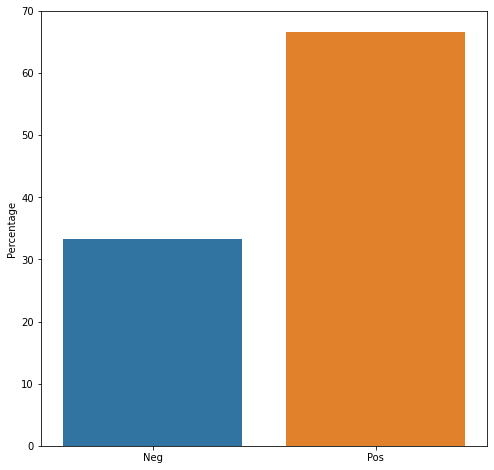

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
counts = df_positive_negative.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Neg', 'Pos'])
ax.set_ylabel('Percentage')
plt.show()

In [15]:
top_20_pos_words = {}
top_20_neg_words = {}
scores= {}
for channelId in LIST_OF_CHANNEL_IDS:
    target_df = channelId_to_sentencedf[channelId]
    positive_words = list(target_df.loc[target_df['pos']==1].sentence)
    positive_frequency = FreqDist(positive_words)
    pos_freq = positive_frequency.most_common(20)
    negative_words = list(target_df.loc[target_df['neg']==1].sentence)
    negative_frequency = FreqDist(negative_words)
    neg_freq = negative_frequency.most_common(20)
    top_20_pos_words[channelId] = pos_freq
    top_20_neg_words[channelId] = neg_freq

    pos_words = [str(p) for p in pos_freq]
    pos_words_str = ', '.join(pos_words)
    neg_words = [str(n) for n in neg_freq]
    neg_words_str = ', '.join(neg_words)
    # generateWordCloud(pos_words_str, neg_words_str)

    scores[channelId] = sum(target_df['compound'])/len(target_df)
# print(scores)

channelName_to_scores = {}
for i in range(0, len(LIST_OF_CHANNEL_NAMES)):
    channelName_to_scores[LIST_OF_CHANNEL_NAMES[i]] = list(scores.values())[i]

avg_score=sum(channelName_to_scores.values())/len(LIST_OF_CHANNEL_NAMES)
print("avg score =", avg_score)
print(channelName_to_scores)
print(sorted(channelName_to_scores.items(), key=lambda item: item[1]))

avg score = 0.07597388354797362
{'Alex Clark': 0.12516857585575097, 'Alex Meyers': 0.10171017334262605, 'WowRightMeow': 0.08816854174131127, 'Andrei Terbea': 0.060722880999895736, 'Billy But Better': 0.08979263685427905, 'Casually Explained': 0.07362420842944016, 'CircleToonsHD': 0.0785860645616513, 'CurtRichy': 0.08384791048467052, 'CypherDen': 0.06808188185542464, 'Daidus': 0.06898366486850932, 'DanPlan': 0.054978589239966985, 'Domics': 0.10238580477972732, 'Emirichu': 0.11027874248445999, 'EroldStory': 0.11507509659290609, 'GradeAUnderA': 0.014606097560975603, 'GetMadz': 0.0916549109182281, 'GingerPale': 0.10900744269127716, 'Ice Cream Sandwich': 0.09104264705882338, 'illymation': 0.0758033845468716, 'Ivan Animated': 0.08914942616679404, 'Jaiden Animations': 0.08062958149207229, 'Let Me Explain Studios': 0.07389520283658356, 'Noodle': 0.06403156293222702, 'OverSimplified': -0.008489563758389367, 'TheOdd1sOut': 0.06449667373130859, 'PantslessPajamas': 0.07381724673710396, 'SomeThingE

In [16]:
sorted_channelName_to_scores = dict(sorted(channelName_to_scores.items(), key=lambda item: item[1]))
sctsdf = pd.DataFrame.from_dict({'channelName':sorted_channelName_to_scores.keys(), 'scores': sorted_channelName_to_scores.values()})
sctsdf

,channelName,scores
0,OverSimplified,-0.008490
1,GradeAUnderA,0.014606
2,Tabbes,0.037002
3,DanPlan,0.054979
4,Andrei Terbea,0.060723
5,Noodle,0.064032
6,TheOdd1sOut,0.064497
7,Young Don The Sauce God,0.065815
8,Zalinki,0.066542
9,SomeThingElseYT,0.067470


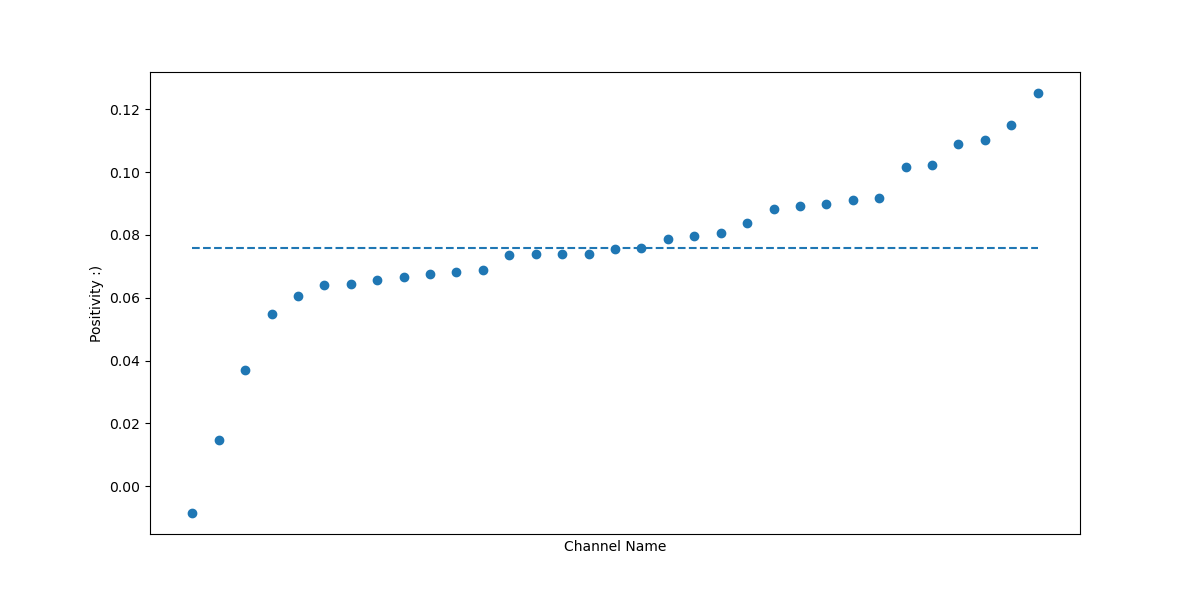

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import mplcursors
%matplotlib widget

x_name = "Channel Name"
y_name = "Positivity :)"
tooltip_name = "positivity value"

x= sctsdf['channelName']
y= sctsdf['scores']
tt = sctsdf['scores']

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(x, y)
# Plot the average line
mean_x=np.arange(0,33,1)
mean_y=[avg_score for i in np.zeros_like(x)]
mean_line = ax.plot(mean_x,mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()


In [18]:
num_of_files = []
for channelId in LIST_OF_CHANNEL_IDS:
    num_of_files.append(len(os.listdir(channelId+"/txt/")))
 
cntvdf = pd.DataFrame.from_dict({'channelName':LIST_OF_CHANNEL_NAMES, 'number of transcripts collected': num_of_files, 'number of vids': LIST_OF_VIDEO_COUNT})

cntvdf

,channelName,number of transcripts collected,number of vids
0,Alex Clark,298,317
1,Alex Meyers,250,256
2,WowRightMeow,27,33
3,Andrei Terbea,112,136
4,Billy But Better,23,23
5,Casually Explained,80,81
6,CircleToonsHD,223,249
7,CurtRichy,89,97
8,CypherDen,58,63
9,Daidus,31,33


In [19]:
representation = sum(cntvdf['number of transcripts collected'])/sum(cntvdf['number of vids'])
print(representation)

0.8760815822002472


In [20]:
#https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff
subsPerYearSinceFirstUpload = channelHolisticInfoDf['subscribersPerYearSinceFirstUpload']

In [21]:
zipped = zip(channelHolisticInfoDf.channelName, channelHolisticInfoDf.subscribersPerYearSinceFirstUpload)
sorted_channelName_to_rescaledSubs = dict(sorted(dict(zipped).items(), key=lambda item: item[1]))
sctrs = pd.DataFrame.from_dict({'channelName': sorted_channelName_to_rescaledSubs.keys(), 'rescaledSubCount': sorted_channelName_to_rescaledSubs.values()})
sctrs

,channelName,rescaledSubCount
0,Ivan Animated,2.420918e+04
1,Billy But Better,5.466590e+04
2,CurtRichy,6.226363e+04
3,Zalinki,7.179712e+04
4,GetMadz,8.528998e+04
5,WowRightMeow,1.083499e+05
6,Young Yong Tales,1.312173e+05
7,Noodle,1.324890e+05
8,PantslessPajamas,1.397693e+05
9,CypherDen,2.047628e+05


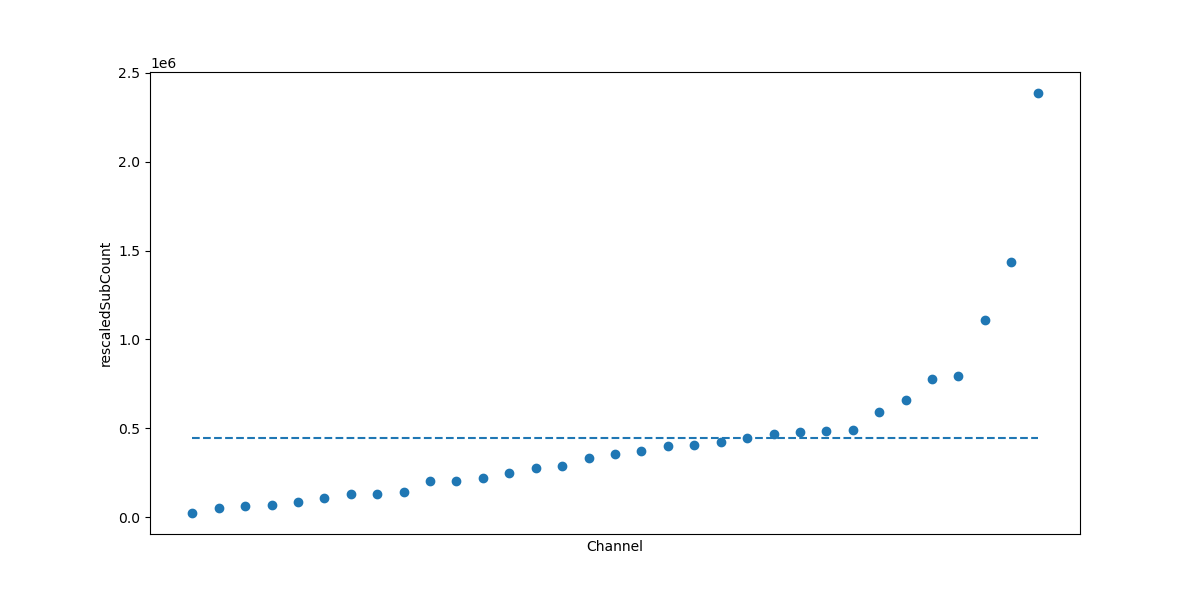

In [56]:
x_name = "Channel"
y_name = "rescaledSubCount"
tooltip_name = "subCountPerYearSinceFirstUpload"

x= sctrs['channelName']
y= sctrs['rescaledSubCount']
tt = sctrs['rescaledSubCount']

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(x, y)
avg_rescaledSubcount= sum(y)/len(LIST_OF_CHANNEL_NAMES)
# Plot the average line
mean_x=np.arange(0,33,1)
mean_y=[avg_rescaledSubcount for i in np.zeros_like(x)]
mean_line = ax.plot(mean_x, mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()

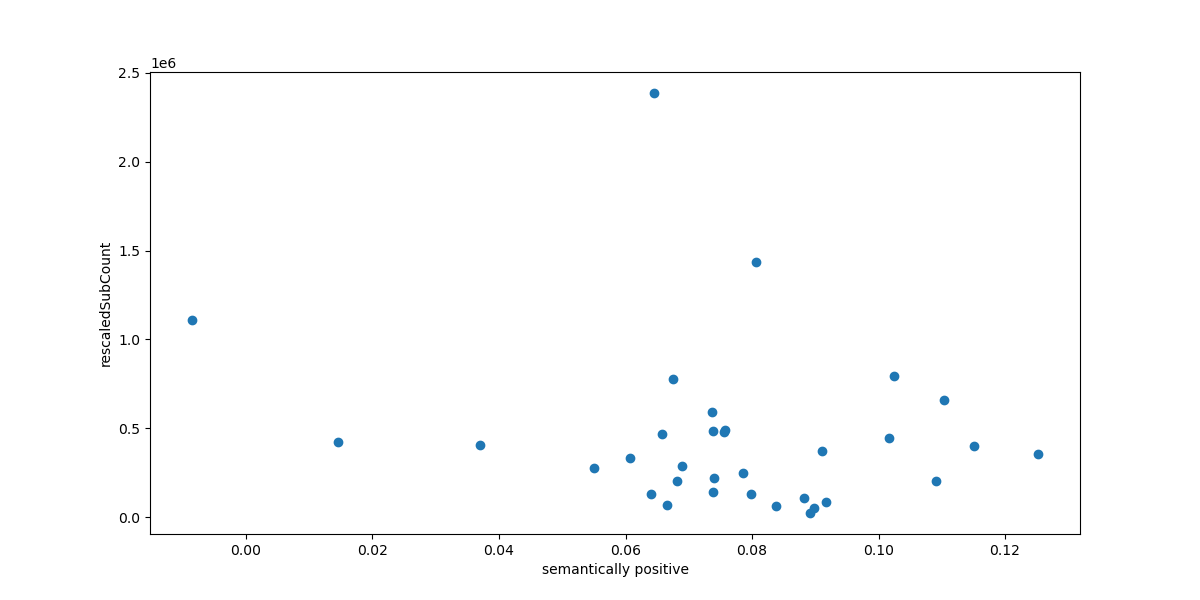

In [87]:
semantic_df = pd.DataFrame.from_dict({'channelName': channelHolisticInfoDf['channelName'], 'rescaledSubCount': subsPerYearSinceFirstUpload, 'positivityScores': channelName_to_scores.values()})
def generate_plot(semantic_df):
    x_name = "semantically positive"
    y_name = "rescaledSubCount"
    tooltip_name = "channelName"
    x= semantic_df['positivityScores']
    y= semantic_df['rescaledSubCount']
    tt = semantic_df[tooltip_name]
    fig, ax = plt.subplots(1, figsize=(12,6))
    sc = ax.scatter(x, y)

    avg_rescaledSubcount= sum(y)/len(LIST_OF_CHANNEL_NAMES)
    # Plot the average line
    mean_x=np.arange(0,33,1)
    mean_y=[avg_rescaledSubcount for i in np.zeros_like(x)]
    # mean_line = ax.plot(mean_x, mean_y, label='Mean', linestyle='--')

    annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(details):
        pos = sc.get_offsets()[details["channelName"]]
        annot.xy = pos
        text = "{}, {}".format(" ".join(details["channelName"]), 
                            " ".join([details["positivityScores"]]))
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, details = sc.contains(event)
            if cont:
                update_annot(details)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    cursor = mplcursors.cursor(sc, hover=True)
    cursor.connect(
    "add", lambda sel: sel.annotation.set_text(tt[sel.index]))
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b)
generate_plot(semantic_df)

Pretty sure Oversimplified (and tbh, Odd1sOut) is messing up my calculations. 

In [76]:
semantic_df = pd.DataFrame.from_dict({'channelName': channelHolisticInfoDf['channelName'], 'rescaledSubCount': subsPerYearSinceFirstUpload, 'positivityScores': channelName_to_scores.values()})
semantic_df

,channelName,rescaledSubCount,positivityScores
0,Alex Clark,3.559353e+05,0.125169
1,Alex Meyers,4.474797e+05,0.101710
2,WowRightMeow,1.083499e+05,0.088169
3,Andrei Terbea,3.315021e+05,0.060723
4,Billy But Better,5.466590e+04,0.089793
5,Casually Explained,5.947656e+05,0.073624
6,CircleToonsHD,2.488131e+05,0.078586
7,CurtRichy,6.226363e+04,0.083848
8,CypherDen,2.047628e+05,0.068082
9,Daidus,2.907246e+05,0.068984


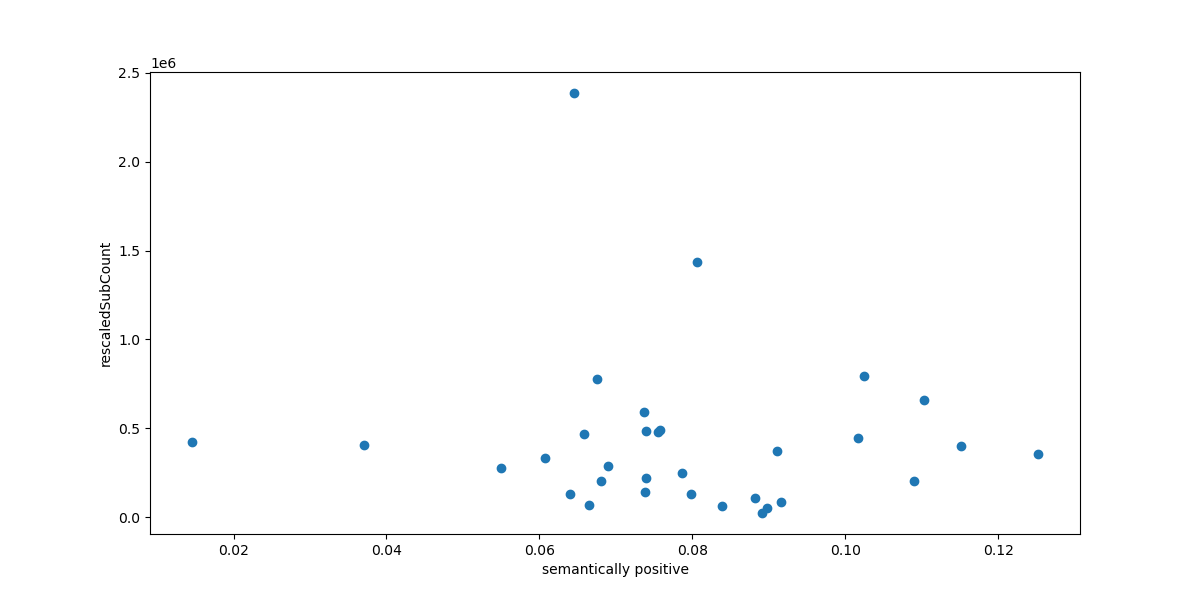

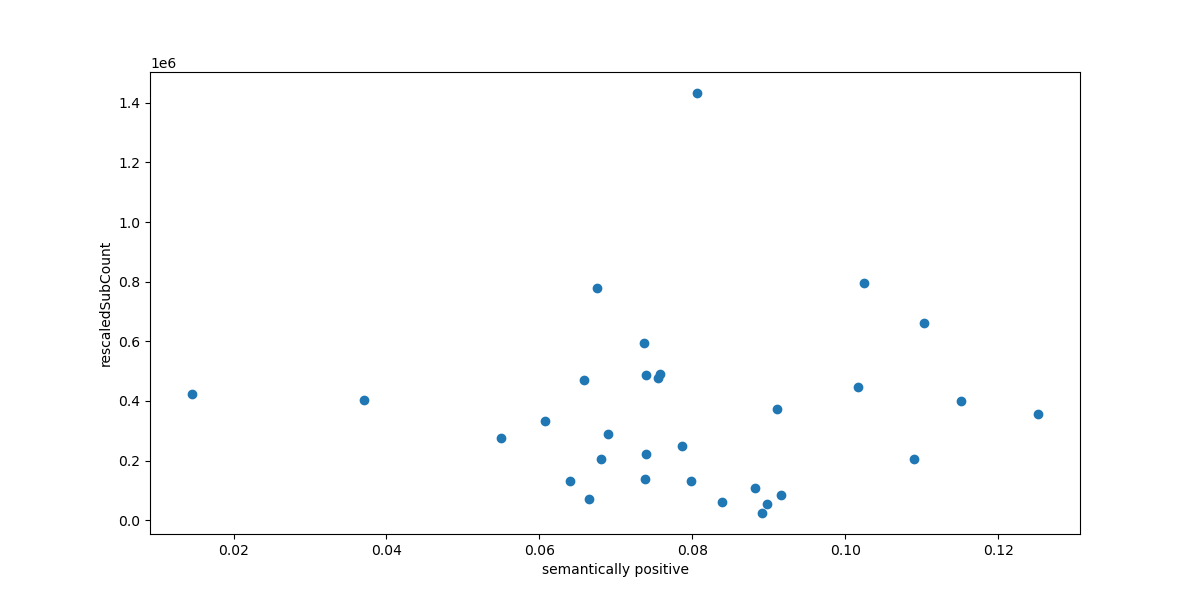

In [91]:
copy_without_oversimplified = semantic_df.drop('23')
copy_without_oversimplified_and_odd1sout = semantic_df.drop(['23', '24'])
semantic_df_copy_without_oversimplified = pd.DataFrame.from_dict(json.loads(json.dumps(copy_without_oversimplified.to_dict())))
semantic_df_copy_without_oversimplified_and_odd1sout = pd.DataFrame.from_dict(json.loads(json.dumps(copy_without_oversimplified_and_odd1sout.to_dict())))

generate_plot(semantic_df_copy_without_oversimplified)
generate_plot(semantic_df_copy_without_oversimplified_and_odd1sout)

So how exactly strong is the correlation? If it's close to 0, then literally, there's no relationship between how positive a channel is. 

In [92]:
import numpy as np
import scipy.stats
x= 'rescaledSubCount'	
y= 'positivityScores'
result = scipy.stats.linregress(semantic_df[x], semantic_df[y])
result_no_oversimplified = scipy.stats.linregress(semantic_df_copy_without_oversimplified[x], semantic_df_copy_without_oversimplified[y])
result_no_odd1sout = scipy.stats.linregress(semantic_df_copy_without_oversimplified_and_odd1sout[x], semantic_df_copy_without_oversimplified_and_odd1sout[y])

print(result.rvalue)
print(result_no_oversimplified.rvalue)
print(result_no_odd1sout.rvalue)

-0.2071749572877414
-0.07678611344603291
0.023909166953822725
